# Kuramoto-Sivashinsky Equation Energy-Preserving Operator Inference

In [1]:
using FFTW
using FileIO
using JLD2
using LaTeXStrings
using LinearAlgebra
using Plots
using ProgressMeter
using SparseArrays
using Statistics

include("../src/model/KS.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

# Settings for the KS equation
KSE = KS(
    [0.0, 100.0], [0.0, 200.0], [1.0, 1.0],
    512, 0.001, 1, "ep"
)

# WARNING:DO YOU WANT TO SAVE DATA?
save_data = true

# Create file name to save data
datafile = "data/kse_data.jld2"
opfile = "data/kse_operators.jld2"
resultfile = "data/kse_results.jld2"

# Settings for Operator Inference
KSE_system = LnL.sys_struct(
    is_lin=true,
    is_quad=true,
)
KSE_vars = LnL.vars(
    N=1,
)
KSE_data = LnL.data(
    Δt=KSE.Δt,
    DS=100,
)
KSE_optim = LnL.opt_settings(
    verbose=false,
    initial_guess=false,
    max_iter=1000,
    reproject=false,
    SIGE=false,
)

options = LnL.LS_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
)

# Downsampling rate
DS = KSE_data.DS

# Down-sampled dimension of the time data
Tdim_ds = size(1:DS:KSE.Tdim, 1)  # downsampled time dimension

# Number of random test inputs
num_test_ic = 50

;


## Generate Training Data

We use the initial condition of 

$$
\begin{gather*}
    u(x,0) = a\cos\left( \frac{2\pi x}{L} \right) + b\cos\left( \frac{4\pi x}{L} \right)
\end{gather*}
$$

where $a$ and $b$ are parameters that vary

In [2]:
# Parameters of the initial condition
ic_a = [0.8, 0.9, 1.0, 1.1]
ic_b = [0.1, 0.2, 0.3, 0.4]

ic_a_out = [-1.0, 3.0]
ic_b_out = [-1.0, 1.0]
num_ic_params = Int(length(ic_a) * length(ic_b))

# Parameterized function for the initial condition
u0 = (a,b) -> a * cos.((2*π*KSE.x)/KSE.Xdim) .+ b * cos.((4*π*KSE.x)/KSE.Xdim)  # initial condition
;  

In [3]:
# Store values
Xtr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # training state data 10x1
Rtr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # training derivative data 10x1
Xtr_all = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_ic_params)  # all training data 10x27
IC_train = Vector{Vector{Float64}}(undef, num_ic_params)  # all initial conditions 
Vr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # POD basis 10x1
Σr = Vector{Vector{Float64}}(undef, KSE.Pdim)  # singular values 10x1
op_fom_tr = Vector{LnL.operators}(undef, KSE.Pdim)  # FOM operators 10x1

@info "Generate the FOM system matrices and training data."
@showprogress for i in eachindex(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A, F = KSE.model_FD(KSE, μ)
    op_fom_tr[i] = LnL.operators(A=A, F=F)

    # Store the training data 
    Xall = Vector{Matrix{Float64}}(undef, num_ic_params)
    Xdotall = Vector{Matrix{Float64}}(undef, num_ic_params)
    
    # Generate the data for all combinations of the initial condition parameters
    ct = 1  # set/reset counter
    for a in ic_a, b in ic_b
        if i == 1
            IC_train[ct] = u0(a, b)
        end

        # A_FFT, F_FFT = KSE.model_FFT_ew(KSE, μ)
        # states, _ = KSE.integrate_FFT_ew(A_FFT, F_FFT, KSE.t, IC_train[ct])

        states = KSE.integrate_FD(A, F, KSE.t, IC_train[ct])
        Xtr_all[i,ct] = states
        
        tmp = states[:, 2:end]
        Xall[ct] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / KSE.Δt
        Xdotall[ct] = tmp[:, 1:DS:end]  # downsample data

        ct += 1  # increment counter
    end
    # Combine all initial condition data to form on big training data matrix
    Xtr[i] = reduce(hcat, Xall) 
    Rtr[i] = reduce(hcat, Xdotall)
    
    # Compute the POD basis from the training data
    tmp = svd(Xtr[i])
    Vr[i] = tmp.U
    Σr[i] = tmp.S
end


### Check Energy-Levels from SVD and Decide Reduced Orders

In [5]:
nice_orders_all = Vector{Vector{Int}}(undef, KSE.Pdim)
energy_level_all = Vector{Vector{Float64}}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    nice_orders_all[i], energy_level_all[i] = LnL.choose_ro(Σr[i]; en_low=-12)
end
nice_orders = Int.(round.(mean(nice_orders_all)))
energy_level = mean(energy_level_all)
;

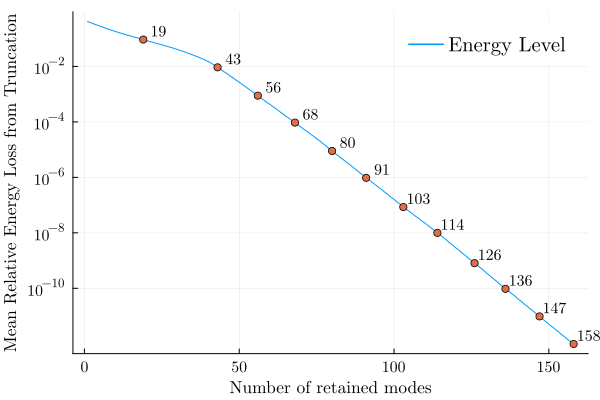

In [6]:
plot(energy_level[1:nice_orders[end]], yaxis=:log10, label="Energy Level", fontfamily="Computer Modern",
    ylabel="Mean Relative Energy Loss from Truncation", xlabel="Number of retained modes", legend=:topright)
plot!(nice_orders, energy_level[nice_orders], seriestype=:scatter, label=nothing)
for i in 1:length(nice_orders)
    annotate!([(nice_orders[i]+5.0, energy_level[nice_orders[i]], text(nice_orders[i], :bottom, 10, "Computer Modern"))])
end
yticks!(10.0 .^ (0:-2:-10))
plot!(fg_legend=:false)
plot!(guidefontsize=11, tickfontsize=10,  legendfontsize=13)

**Based on the energy levels we select an appropriate reduced-order**

In [7]:
# Minimum and maximum dimensions
ro = nice_orders[3:8]
;

## Generate Test Data (Inside Training Region)

Generate random initial condition parameters from the training region for $\mu \in M$.

In [ ]:
# Store values
Xtest_in = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_test_ic)  # all training data 
IC_test_in = Vector{Vector{Float64}}(undef, num_test_ic)  # all initial conditions

@info "Generate test data for parameters within the training region."

# Generate 10 random initial condition parameters
ic_a_rand_in = (maximum(ic_a) - minimum(ic_a)) .* rand(num_test_ic) .+ minimum(ic_a)
ic_b_rand_in = (maximum(ic_b) - minimum(ic_b)) .* rand(num_test_ic) .+ minimum(ic_b)
ic_c_rand_in = (maximum(ic_c) - minimum(ic_c)) .* rand(num_test_ic) .+ minimum(ic_c)

@showprogress for i in eachindex(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A = op_fom_tr[i].A
    F = op_fom_tr[i].F

    # Generate the data for all combinations of the initial condition parameters
    for j in 1:num_test_ic  
        a = ic_a_rand_in[j]
        b = ic_b_rand_in[j]
        c = ic_c_rand_in[j]

        if i == 1
            IC_test_in[j] = u0(a, b, c)
        end
        Xtest_in[i,j] = KSE.integrate_FD(A, F, KSE.t, IC_test_in[j])
    end
end

# if save_data
#     Data["Xtest_in"] = Xtest_in
#     Data["IC_test_in"] = IC_test_in
#     @save filename Data
# end

## Generate Test Data (Outside Training Region)

Generate random initial condition parameters outside of the training region for $\mu \in M$.

In [ ]:
# Store values
Xtest_out = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_test_ic)  # all training data 
IC_test_out = Vector{Vector{Float64}}(undef, num_test_ic)  # all initial conditions

@info "Generate test data for parameters outside the training region."

# Generate 10 random initial condition parameters outside the training region
ϵ=1e-2
half_num_test_ic = Int(num_test_ic/2)
ic_a_rand_out = ((minimum(ic_a) - ϵ) - ic_a_out[1]) .* rand(half_num_test_ic) .+ ic_a_out[1]
append!(ic_a_rand_out, (ic_a_out[2] - (maximum(ic_a) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_a) + ϵ))
ic_b_rand_out = ((minimum(ic_b) - ϵ) - ic_b_out[1]) .* rand(half_num_test_ic) .+ ic_b_out[1]
append!(ic_b_rand_out, (ic_b_out[2] - (maximum(ic_b) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_b) + ϵ))
ic_c_rand_out = ((minimum(ic_c) - ϵ) - ic_c_out[1]) .* rand(half_num_test_ic) .+ ic_c_out[1]
append!(ic_c_rand_out, (ic_c_out[2] - (maximum(ic_c) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_c) + ϵ))

@showprogress for i in eachindex(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A = op_fom_tr[i].A
    F = op_fom_tr[i].F

    # Generate the data for all combinations of the initial condition parameters
    for j in 1:num_test_ic
        a = ic_a_rand_out[j]
        b = ic_b_rand_out[j]
        c = ic_c_rand_out[j]

        if i == 1
            IC_test_out[j] = u0(a, b, c)
        end
        Xtest_out[i,j] = KSE.integrate_FD(A, F, KSE.t, IC_test_out[j])
    end
end

# if save_data
#     Data["Xtest_out"] = Xtest_out
#     Data["IC_test_out"] = IC_test_out
#     @save filename Data
# end

### Save data

In [8]:
if save_data
    save(
        datafile,
        Dict("Xtr" => Xtr, "Rtr" => Rtr, "Vr" => Vr, 
            "op_fom_tr" => op_fom_tr, 
            "Xtr_all" => Xtr_all, "IC_train" => IC_train,
            "ro" => ro
        )
    )
end

## Obtain Operators using Least-Squares (Vanilla) Operator Inference

In [9]:
@info "Compute the Least Squares solution."

options = LnL.LS_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    pinv_tol = 1e-4,   # tolerance for pseudo-inverse
)

# Store values
op_LS = Array{LnL.operators}(undef, KSE.Pdim)

@showprogress for i in eachindex(KSE.μs)
    op_LS[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
end

┌ Info: Compute the Least Squares solution.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


┌ Warning: Rank difficient, rank = 5127, tol = 9.994142344249913e-5.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:89


## Compute intrusive operators

In [8]:
@info "Compute the intrusive model"

# Store values
op_int = Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    # Compute the values for the intrusive model from the basis of the training data
    op_int[i] = LnL.intrusiveMR(op_fom_tr[i], Vr[i][:, 1:ro[end]], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

┌ Info: Compute the intrusive model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:9


## Computer EPHEC-OpInf operators

In [5]:
@info "Compute the EPHEC model"

options = LnL.EPHEC_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
)
op_ephec =  Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    op_ephec[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

┌ Info: Compute the EPHEC model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


OutOfMemoryError: OutOfMemoryError()

## Compute EPSIC-Opinf operators

In [ ]:
@info "Compute the EPSIC OpInf."

options = LnL.EPSIC_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    ϵ=1e-3,
)
op_epsic = Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    op_epsic[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

## Compute EPP-OpInf operators

In [ ]:
@info "Compute the EPUC OpInf."

options = LnL.EPP_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    α=1e6,
)
op_epp =  Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    op_epp[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

### Save the operators

In [10]:
save(opfile, Dict("op_LS" => op_LS, "op_int" => op_int))

In [ ]:
if save_data
    save(
        opfile,
        Dict("op_LS" => op_LS, "op_int" => op_int, "op_ephec" => op_ephec, 
            "op_epsic" => op_epsic, "op_epp" => op_epp)
    )
end

## Analyze Training Results

### Load the data

In [3]:
DATA = load(datafile);

In [4]:
OPS = load(opfile);

In [ ]:
RES = load(resultfile)
RES = Dict{String, Any}(RES); # convert type to avoid errors

In [10]:
# Setup the results
RES["train_proj_err"] = Array{Float64}(undef, length(ro), KSE.Pdim) 
RES["train_state_err"] = Dict(
    :int => Array{Float64}(undef, length(ro), KSE.Pdim),
    :LS => Array{Float64}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epp => Array{Float64}(undef, length(ro), KSE.Pdim),
)
RES["train_CR"] = Dict(
    :int => Array{Float64}(undef, length(ro), KSE.Pdim),
    :LS => Array{Float64}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epp => Array{Float64}(undef, length(ro), KSE.Pdim),
    :fom => Array{Float64}(undef, KSE.Pdim)
)
;

In [28]:
function analyze_proj_err(model, X_all, Vr_all, IC, ro)
    num_ic_params = length(IC)
    PE_all = Array{Float64}(undef, length(ro), model.Pdim) 
    
    @showprogress for i in eachindex(model.μs)
        for (j,r) in enumerate(ro)
            PE = Array{Float64}(undef, num_ic_params)  
            Vr = Vr_all[i][:, 1:r]
            for (ct, ic) in enumerate(IC)
                PE[ct] = LnL.compProjError(X_all[i,ct], Vr)
            end
            PE_all[j, i] = mean(PE)
        end
    end
    return PE_all
end

analyze_proj_err (generic function with 2 methods)

In [40]:
function analyze_rse(op, model, X_all, Vr_all, IC, ro, DS, integrator)
    # Relative state error
    RSE_all = Array{Float64}(undef, length(ro), model.Pdim)
    num_ic_params = length(IC)

    @showprogress for i in eachindex(model.μs)
        for (j,r) in enumerate(ro)
            Vr = Vr_all[i][:, 1:r]
            RSE = Array{Float64}(undef, num_ic_params)

            for (ct, ic) in enumerate(IC)
                Fextract = LnL.extractF(op[i].F, r)
                X = integrator(op[i].A[1:r, 1:r], Fextract, model.t, Vr' * ic)
                RSE[ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], X[:, 1:DS:end], Vr)
            end
            RSE_all[j, i] = mean(RSE)
        end
    end
    return RSE_all
end

analyze_rse (generic function with 2 methods)

In [12]:
function analyze_cr(op, ForH, model, ro)
    CR_all = Array{Float64}(undef, length(ro), model.Pdim)
    num_ic_params = length(IC)

    @showprogress for i in eachindex(model.μs)
        for (j,r) in enumerate(ro)
            CR = Vector{Float64}(undef, num_ic_params)

            for (ct, ic) in enumerate(IC)
                Fextract = LnL.extractF(op[i].F, r)
                CR[ct], _ =  LnL.constraintResidual(Fextract, r, ForH)
            end
            CR_all[j, i] = mean(CR)
        end
    end
    return CR_all
end

analyze_cr (generic function with 1 method)

In [14]:
function fom_CR(op, ForH, model)
    CR = Array{Float64}(undef, model.Pdim)
    @showprogress for i in 1:length(model.μs)
        F_full = op[i].F
        CR[i], _ = LnL.constraintResidual(F_full, size(F_full, 1), ForH)
    end
    return CR
end

fom_CR (generic function with 1 method)

In [15]:
# Compute CR of full order model
RES["train_CR"][:fom] = fom_CR(DATA["op_fom_tr"], "F", KSE)

1-element Vector{Float64}:
 1.3322676295501878e-15

### __old__

In [ ]:
function EP_analyze(Data, model, integrator, options, X_all, IC; rmin=1, rmax=10, ro=nothing)

    # Projection error
    if isnothing(ro)
        ro_dim = rmax - (rmin - 1)
    else
        ro_dim = length(ro)
    end

    PE_all = Array{Float64}(undef, ro_dim, model.Pdim) 
    # Relative state error
    SE_all = Dict(
        :int => Array{Float64}(undef, ro_dim, model.Pdim),
        :LS => Array{Float64}(undef, ro_dim, model.Pdim),
        :ephec => Array{Float64}(undef, ro_dim, model.Pdim),
        :epsic => Array{Float64}(undef, ro_dim, model.Pdim),
        :epp => Array{Float64}(undef, ro_dim, model.Pdim),
    )
    # Energy 
    EN_all = Dict(
        :int => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :LS => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :ephec => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :epsic => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :epp => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :fom => Array{VecOrMat{Float64}}(undef, model.Pdim)
    )
    # Constraint Residual
    CR_all = Dict(
        :int => Array{Float64}(undef, ro_dim, model.Pdim),
        :LS => Array{Float64}(undef, ro_dim, model.Pdim),
        :ephec => Array{Float64}(undef, ro_dim, model.Pdim),
        :epsic => Array{Float64}(undef, ro_dim, model.Pdim),
        :epp => Array{Float64}(undef, ro_dim, model.Pdim),
        :fom => Array{Float64}(undef, model.Pdim)
    )
    # Momentum
    MMT_all = Dict(
        :int => Array{Float64}(undef, ro_dim, model.Pdim),
        :LS => Array{Float64}(undef, ro_dim, model.Pdim),
        :ephec => Array{Float64}(undef, ro_dim, model.Pdim),
        :epsic => Array{Float64}(undef, ro_dim, model.Pdim),
        :epp => Array{Float64}(undef, ro_dim, model.Pdim),
        :fom => Array{Float64}(undef, model.Pdim)
    )
    # Constraint Violation
    CV_all = Dict(
        :int => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :LS => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :ephec => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :epsic => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :epp => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :fom => Array{VecOrMat{Float64}}(undef, model.Pdim)
    )

    # Load values
    op_LS = Data["op_LS"]
    op_int = Data["op_int"]
    # op_ephec = Data["op_ephec"]
    # op_epsic = Data["op_epsic"]
    # op_epp = Data["op_epp"]
    Vrmax = Data["Vr"]

    num_ic_params = length(IC)

    @info "Analyze the operators with training data..."
    @showprogress for i in 1:length(model.μs)

        # Energy, constraint residual, and constraint violation of the FOM
        EN_all[:fom][i] = norm.(eachcol(X_all[i]), 2)
        F_full = Data["op_fom_tr"][i].F
        CR_all[:fom][i], MMT_all[:fom][i] = LnL.constraintResidual(F_full, size(F_full, 1), options.optim.which_quad_term)
        CV_all[:fom][i] = LnL.constraintViolation(X_all[i], F_full, options.optim.which_quad_term)

        if isnothing(ro)
            ro = rmin:rmax
        end
        
        for (j,r) in enumerate(ro)
            Vr = Vrmax[i][:, 1:r]

            # Temporary data storage
            PE = Array{Float64}(undef, num_ic_params)  # projection error
            SE = Dict(
                :int => Array{Float64}(undef, num_ic_params),
                :LS => Array{Float64}(undef, num_ic_params),
                :ephec => Array{Float64}(undef, num_ic_params),
                :epsic => Array{Float64}(undef, num_ic_params),
                :epp => Array{Float64}(undef, num_ic_params),
            )
            En = Dict(
                :int => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :LS => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :ephec => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epsic => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epp => Matrix{Float64}(undef, num_ic_params, model.Tdim),
            )
            CR = Dict(
                :int => Vector{Float64}(undef, num_ic_params),
                :LS => Vector{Float64}(undef, num_ic_params),
                :ephec => Vector{Float64}(undef, num_ic_params),
                :epsic => Vector{Float64}(undef, num_ic_params),
                :epp => Vector{Float64}(undef, num_ic_params),
            )
            mmt = Dict(
                :int => Vector{Float64}(undef, num_ic_params),
                :LS => Vector{Float64}(undef, num_ic_params),
                :ephec => Vector{Float64}(undef, num_ic_params),
                :epsic => Vector{Float64}(undef, num_ic_params),
                :epp => Vector{Float64}(undef, num_ic_params),
            )
            CV = Dict(
                :int => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :LS => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :ephec => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epsic => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epp => Matrix{Float64}(undef, num_ic_params, model.Tdim),
            )

            for (ct, ic) in enumerate(IC)

                # Integrate the LS operator inference model
                Finf_extract_LS = LnL.extractF(op_LS[i].F, r)
                Xinf_LS = integrator(op_LS[i].A[1:r, 1:r], Finf_extract_LS, KSE.t, Vr' * ic)

                # Integrate the intrusive model
                Fint_extract = LnL.extractF(op_int[i].F, r)
                Xint = integrator(op_int[i].A[1:r, 1:r], Fint_extract, KSE.t, Vr' * ic)
                
                # if options.optim.SIGE
                #     # Integrate the energy-preserving hard equality constraint operator inference model
                #     Finf_extract_ephec = op_ephec[i,j].F
                #     Xinf_ephec = integrator(op_ephec[i,j].A, op_ephec[i,j].F, KSE.t, Vr' * ic)
                #     # Finf_extract_ephec = LnL.extractF(op_ephec[i,rmax].F, r)
                #     # Xinf_ephec = integrator(op_ephec[i,rmax].A[1:r, 1:r], Finf_extract_ephec, KSE.t, Vr' * ic)
                    
                #     # Integrate the energy-preserving soft inequality constraint operator inference model
                #     Finf_extract_epsic = op_epsic[i,j].F
                #     Xinf_epsic = integrator(op_epsic[i,j].A, op_epsic[i,j].F, KSE.t, Vr' * ic)
                #     # Finf_extract_epsic = LnL.extractF(op_epsic[i,rmax].F, r)
                #     # Xinf_epsic = integrator(op_epsic[i,rmax].A[1:r, 1:r], Finf_extract_epsic, KSE.t, Vr' * ic)

                #     # Integrate the energy-preserving unconstrained operator inference model
                #     Finf_extract_epp = op_epp[i,j].F
                #     Xinf_epp = integrator(op_epp[i,j].A, op_epp[i,j].F, KSE.t, Vr' * ic)
                #     # Finf_extract_epuc = LnL.extractF(op_epuc[i,rmax].F, r)
                #     # Xinf_epuc = integrator(op_epuc[i,rmax].A[1:r, 1:r], Finf_extract_epuc, KSE.t, Vr' * ic)
                # else
                #     # Integrate the energy-preserving hard equality constraint operator inference model
                #     Finf_extract_ephec = LnL.extractF(op_ephec[i].F, r)
                #     Xinf_ephec = integrator(op_ephec[i].A[1:r, 1:r], Finf_extract_ephec, KSE.t, Vr' * ic)
                    
                #     # Integrate the energy-preserving soft inequality constraint operator inference model
                #     Finf_extract_epsic = LnL.extractF(op_epsic[i].F, r)
                #     Xinf_epsic = integrator(op_epsic[i].A[1:r, 1:r], Finf_extract_epsic, KSE.t, Vr' * ic)

                #     # Integrate the energy-preserving unconstrained operator inference model
                #     Finf_extract_epp = LnL.extractF(op_epp[i].F, r)
                #     Xinf_epp = integrator(op_epp[i].A[1:r, 1:r], Finf_extract_epp, KSE.t, Vr' * ic)
                # end

                # Compute the projection error
                PE[ct] = LnL.compProjError(X_all[i,ct], Vr)

                # Compute the relative state error
                SE[:LS][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_LS[:, 1:DS:end], Vr)
                SE[:int][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xint[:, 1:DS:end], Vr)
                # SE[:ephec][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_ephec[:, 1:DS:end], Vr)
                # SE[:epsic][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_epsic[:, 1:DS:end], Vr)
                # SE[:epp][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_epp[:, 1:DS:end], Vr)

                # Compute the energy
                En[:LS][ct, :] .= norm.(eachcol(Vr * Xinf_LS), 2)
                En[:int][ct, :] .= norm.(eachcol(Vr * Xint), 2)
                # En[:ephec][ct, :] .= norm.(eachcol(Vr * Xinf_ephec), 2)
                # En[:epsic][ct, :] .= norm.(eachcol(Vr * Xinf_epsic), 2)
                # En[:epp][ct, :] .= norm.(eachcol(Vr * Xinf_epp), 2)

                # Compute the constraint residual and momentum
                CR[:LS][ct], mmt[:LS][ct] =  LnL.constraintResidual(Finf_extract_LS, r, options.optim.which_quad_term)
                CR[:int][ct], mmt[:int][ct] = LnL.constraintResidual(Fint_extract, r, options.optim.which_quad_term)
                # CR[:ephec][ct], mmt[:ephec][ct] = LnL.constraintResidual(Finf_extract_ephec, r, options.optim.which_quad_term)
                # CR[:epsic][ct], mmt[:epsic][ct] = LnL.constraintResidual(Finf_extract_epsic, r, options.optim.which_quad_term)
                # CR[:epp][ct], mmt[:epp][ct] = LnL.constraintResidual(Finf_extract_epp, r, options.optim.which_quad_term)

                # Compute the constraint violation
                CV[:LS][ct, :] .= LnL.constraintViolation(Xinf_LS, Finf_extract_LS, options.optim.which_quad_term)
                CV[:int][ct, :] .= LnL.constraintViolation(Xint, Fint_extract, options.optim.which_quad_term)
                # CV[:ephec][ct, :] .= LnL.constraintViolation(Xinf_ephec, Finf_extract_ephec, options.optim.which_quad_term)
                # CV[:epsic][ct, :] .= LnL.constraintViolation(Xinf_epsic, Finf_extract_epsic, options.optim.which_quad_term)
                # CV[:epp][ct, :] .= LnL.constraintViolation(Xinf_epp, Finf_extract_epp, options.optim.which_quad_term)
            end

            # Compute errors
            PE_all[j, i] = mean(PE)
            SE_all[:LS][j, i] = mean(SE[:LS])
            SE_all[:int][j, i] = mean(SE[:int])
            # SE_all[:ephec][j, i] = mean(SE[:ephec])
            # SE_all[:epsic][j, i] = mean(SE[:epsic])
            # SE_all[:epp][j, i] = mean(SE[:epp])
            
            # Compute energy 
            EN_all[:LS][j, i] = mean(En[:LS], dims=1)
            EN_all[:int][j, i] = mean(En[:int], dims=1)
            # EN_all[:ephec][j, i] = mean(En[:ephec], dims=1)
            # EN_all[:epsic][j, i] = mean(En[:epsic], dims=1)
            # EN_all[:epp][j, i] = mean(En[:epp], dims=1)
            
            # Compute the CR and momentum
            CR_all[:LS][j, i] = mean(CR[:LS])
            CR_all[:int][j, i] = mean(CR[:int])
            # CR_all[:ephec][j, i] = mean(CR[:ephec])
            # CR_all[:epsic][j, i] = mean(CR[:epsic])
            # CR_all[:epp][j, i] = mean(CR[:epp])

            MMT_all[:LS][j, i] = mean(mmt[:LS])
            MMT_all[:int][j, i] = mean(mmt[:int])
            # MMT_all[:ephec][j, i] = mean(mmt[:ephec])
            # MMT_all[:epsic][j, i] = mean(mmt[:epsic])
            # MMT_all[:epp][j, i] = mean(mmt[:epp])

            # Compute constraint violations
            CV_all[:LS][j, i] = mean(CV[:LS], dims=1)
            CV_all[:int][j, i] = mean(CV[:int], dims=1)
            # CV_all[:ephec][j, i] = mean(CV[:ephec], dims=1)
            # CV_all[:epsic][j, i] = mean(CV[:epsic], dims=1)
            # CV_all[:epp][j, i] = mean(CV[:epp], dims=1)
        end
    end

    Data = Dict{String, Any}(Data)  # convert type to avoid errors
    Data["train_proj_err"] = PE_all
    Data["train_state_err"] = SE_all
    Data["train_En"] = EN_all
    Data["train_CR"] = CR_all
    Data["train_mmt"] = MMT_all
    Data["train_CV"] = CV_all

    return Data
end
;


In [ ]:
# Data["train_proj_err"], Data["train_state_err"], Data["train_En"], Data["train_CR"], Data["train_mmt"], Data["train_CV"] = EP_analyze(Data,KSE,KSE.integrate_FD,options,Data["Xtr_all"],Data["IC_train"],rmin,rmax)
Data = EP_analyze(Data,KSE,KSE.integrate_FD,options,Data["Xtr_all"],Data["IC_train"];ro=Data["ro"])

### Projection error

In [27]:
RES["train_proj_err"] = analyze_proj_err(KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"]);

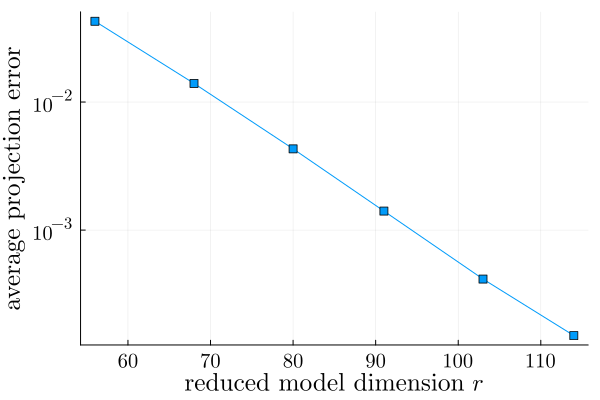

In [37]:
# Training data
mean_train_proj_err = mean(RES["train_proj_err"], dims=2)
plot(DATA["ro"], mean_train_proj_err, marker=(:rect), fontfamily="Computer Modern")
plot!(yscale=:log10, majorgrid=true, legend=false)
# tmp = log10.(mean_train_proj_err)
# yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
# xticks!()
xlabel!("reduced model dimension " * L"r")
ylabel!("average projection error")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)

### Relative state error

In [41]:
# Least-squares
RES["train_state_err"][:LS] = analyze_rse(OPS["op_LS"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

In [44]:
RES["train_state_err"][:LS]

6×1 Matrix{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [ ]:
# Intrusive
RES["train_state_err"][:int] = analyze_rse(OPS["op_int"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

In [ ]:
# EPHEC
RES["train_state_err"][:ephec] = analyze_rse(OPS["op_ephec"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

In [ ]:
# EPSIC
RES["train_state_err"][:epsic] = analyze_rse(OPS["op_epsic"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.epsicegrate_FD);

In [ ]:
# EPP
RES["train_state_err"][:epp] = analyze_rse(OPS["op_epp"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.eppegrate_FD);

In [ ]:
mean_LS_state_err = mean(RES["train_state_err"][:LS], dims=2)
mean_int_state_err = mean(RES["train_state_err"][:int], dims=2)
mean_ephec_state_err = mean(RES["train_state_err"][:ephec], dims=2)
mean_epsic_state_err = mean(RES["train_state_err"][:epsic], dims=2)
mean_epp_state_err = mean(RES["train_state_err"][:epp], dims=2)

plot(Data["ro"], mean_LS_state_err, c=:black, marker=(:circle, 3.5, :black), label=L"\mathrm{opinf}")
plot!(Data["ro"], mean_int_state_err, c=:orange, marker=(:cross, 8, :orange), label=L"\mathrm{intrusive}")
plot!(Data["ro"], mean_ephec_state_err, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(Data["ro"], mean_epsic_state_err, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(Data["ro"], mean_epp_state_err, c=:red, markerstrokecolor=:red, marker=(:star, 4), lw=1, ls=:dash, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomleft)
# tmp = log10.(mean_int_state_err)
# yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
# xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension~} r")
ylabel!(L"\mathrm{average~~relative~~state~~error}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)


### Constraint Residual

In [ ]:
# Least-squares
RES["train_CR"][:LS] = analyze_cr(OPS["op_LS"], "F", KSE, DATA["ro"])

In [ ]:
# Intrusive
RES["train_CR"][:int] = analyze_cr(OPS["op_int"], "F", KSE, DATA["ro"])

In [ ]:
# EPHEC
RES["train_CR"][:ephec] = analyze_cr(OPS["op_ephec"], "F", KSE, DATA["ro"])

In [ ]:
# EPSIC
RES["train_CR"][:epsic] = analyze_cr(OPS["op_epsic"], "F", KSE, DATA["ro"])

In [ ]:
# EPP
RES["train_CR"][:epp] = analyze_cr(OPS["op_epp"], "F", KSE, DATA["ro"])

In [ ]:
mean_LS_CR_tr = mean(RES["train_CR"][:LS], dims=2)
mean_int_CR_tr = mean(RES["train_CR"][:int], dims=2)
mean_ephec_CR_tr = mean(RES["train_CR"][:ephec], dims=2)
mean_epsic_CR_tr = mean(RES["train_CR"][:epsic], dims=2)
mean_epp_CR_tr = mean(RES["train_CR"][:epp], dims=2)
mean_fom_CR_tr = mean(RES["train_CR"][:fom])

plot(Data["ro"], mean_LS_CR_tr, marker=(:circle, 3.5), c=:black, label=L"\mathrm{opinf}")
plot!(Data["ro"], mean_int_CR_tr, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
plot!(rmin:rmax, mean_ephec_CR_tr, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, mean_epsic_CR_tr, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, mean_epp_CR_tr, c=:red, markerstrokecolor=:red, marker=(:star, 4), ls=:dash, lw=1, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomright, minorgridalpha=0.03)
yticks!(10.0 .^ [-15, -12, -9, -6, -3, 0, 3])
xlabel!(L"\mathrm{reduced~model~dimension}~r")
ylabel!(L"\mathrm{constraint~~residual}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=11)

In [43]:
save(resultfile, RES);